In [1]:
import sys
import numpy as np
import keras
from keras.utils import Sequence
from PIL import Image
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
import imgaug as ia
from imgaug import augmenters as iaa
import cv2

Using TensorFlow backend.


In [2]:
BATCH_SIZE = 128
SHAPE = (192, 192, 4)
SEED = 777
PATH = '../input/human-protein-atlas-image-classification'
VALIDATION_PERCENT = 0.1
THRESHOLD = 0.05 
LEARNING_RATE = 0.05
ia.seed(SEED)

In [3]:
def getLabeledDataset():
    
    path_to_train = PATH + '/train/'
    data = pd.read_csv(PATH + '/train.csv')

    paths = []
    labels = []
    
    for name, lbl in zip(data['Id'], data['Target'].str.split(' ')):
        y = np.zeros(28)
        for key in lbl:
            y[int(key)] = 1
        paths.append(os.path.join(path_to_train, name))
        labels.append(y)

    return np.array(paths), np.array(labels)

def getTestDataset():
    
    path_to_test = PATH + '/test/'
    data = pd.read_csv(PATH + '/sample_submission.csv')

    paths = []
    labels = []
    
    for name in data['Id']:
        y = np.ones(28)
        paths.append(os.path.join(path_to_test, name))
        labels.append(y)

    return np.array(paths), np.array(labels)

paths, labels = getLabeledDataset()
testPaths, testLabels = getTestDataset()

In [4]:
# generate train set and validation set from labeled data
keys = np.arange(paths.shape[0], dtype=np.int)  
np.random.seed(SEED)
np.random.shuffle(keys)
trainCount = int((1-VALIDATION_PERCENT) * paths.shape[0])

trainPaths = paths[0:trainCount]
trainLabels = labels[0:trainCount]
validationPaths = paths[trainCount:]
validationLabels = labels[trainCount:]

In [5]:
from keras.models import Sequential, load_model, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, ReLU, LeakyReLU
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import metrics
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import keras
import tensorflow as tf

from tensorflow import set_random_seed
set_random_seed(SEED)

In [6]:
class DataGenerator(keras.utils.Sequence):
            
    def __init__(self, paths, labels, batch_size, shape, shuffle = False, use_cache = False, augment = False):
        self.paths = paths
        self.labels = labels
        self.batch_size = batch_size
        self.shape = shape
        self.shuffle = shuffle
        self.use_cache = use_cache
        self.augment = augment
        if use_cache == True:
            self.cache = np.zeros((paths.shape[0], shape[0], shape[1], shape[2]), dtype=np.float16)
            self.is_cached = np.zeros((paths.shape[0]))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]

        paths = self.paths[indexes]
        X = np.zeros((paths.shape[0], self.shape[0], self.shape[1], self.shape[2]))
        if self.use_cache == True:
            X = self.cache[indexes]
            for i, path in enumerate(paths[np.where(self.is_cached[indexes] == 0)]):
                image = self.__load_image(path)
                self.is_cached[indexes[i]] = 1
                self.cache[indexes[i]] = image
                X[i] = image
        else:
            for i, path in enumerate(paths):
                X[i] = self.__load_image(path)

        y = self.labels[indexes]
                
        if self.augment == True:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5), # horizontal flips
                    iaa.Crop(percent=(0, 0.1)), # random crops
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.ContrastNormalization((0.75, 1.5)),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])], random_order=True)

            X = np.concatenate((X, seq.augment_images(X), seq.augment_images(X), seq.augment_images(X)), 0)
            y = np.concatenate((y, y, y, y), 0)
        return X, y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        R = Image.open(path + '_red.png')
        G = Image.open(path + '_green.png')
        B = Image.open(path + '_blue.png')
        Y = Image.open(path + '_yellow.png')
        im = np.stack((
            np.array(R), 
            np.array(G), 
            np.array(B),
            np.array(Y)), -1)
        im = cv2.resize(im, (SHAPE[0], SHAPE[1]))
        im = np.divide(im, 255)
        return im

In [7]:
trainGenerator = DataGenerator(trainPaths, trainLabels, BATCH_SIZE, SHAPE, use_cache=True, augment = False, shuffle = False)
validationGenerator = DataGenerator(validationPaths, validationLabels, BATCH_SIZE, SHAPE, use_cache=True, shuffle = False)

modelCheckpoint = ModelCheckpoint('./base.model', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min')

In [8]:
def f1(y_true, y_pred):
    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1-K.mean(f1)

In [9]:
def vgg16likeModel(input_shape):
    dropRate = 0.25
    
    input_layer = Input(input_shape)
    
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(input_layer)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv4')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv4')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv4')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    x = Flatten()(x)

    x = Dense(4096)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(4096, name='fc2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(28)(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    
    return model

In [10]:
def create_model(input_shape):
    
    dropRate = 0.25
    
    init = Input(input_shape)
    x = BatchNormalization(axis=-1)(init)
    x = Conv2D(8, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(8, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(16, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropRate)(x)
    c1 = Conv2D(16, (3, 3), padding='same')(x)
    c1 = ReLU()(c1)
    c2 = Conv2D(16, (5, 5), padding='same')(x)
    c2 = ReLU()(c2)
    c3 = Conv2D(16, (7, 7), padding='same')(x)
    c3 = ReLU()(c3)
    c4 = Conv2D(16, (1, 1), padding='same')(x)
    c4 = ReLU()(c4)
    x = Concatenate()([c1, c2, c3, c4])
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropRate)(x)
    x = Conv2D(32, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropRate)(x)
    x = Conv2D(64, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropRate)(x)
    x = Conv2D(128, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropRate)(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(28)(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Dropout(0.1)(x)
    x = Dense(28)(x)
    x = Activation('sigmoid')(x)
    
    model = Model(init, x)
    
    return model

In [11]:
model = create_model(SHAPE)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(LEARNING_RATE),
    metrics=['acc',f1])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 192, 4)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 192, 192, 4)  16          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 190, 190, 8)  296         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 190, 190, 8)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [12]:
epochs = 10

hist = model.fit_generator(
    trainGenerator,
    steps_per_epoch=len(trainGenerator),
    validation_data=validationGenerator,
    validation_steps=8,
    epochs=epochs,
    use_multiprocessing=False,
    workers=1,
    verbose=1,
    callbacks=[modelCheckpoint])

Epoch 1/10
219/219 [==============================] - 2550s 12s/step - loss: 0.1867 - acc: 0.9347 - f1: 0.1001 - val_loss: 0.2297 - val_acc: 0.9166 - val_f1: 0.0875

Epoch 00001: val_loss improved from inf to 0.22967, saving model to ./base.model
Epoch 2/10
219/219 [==============================] - 2244s 10s/step - loss: 0.1603 - acc: 0.9467 - f1: 0.1191 - val_loss: 0.1859 - val_acc: 0.9393 - val_f1: 0.1200

Epoch 00002: val_loss improved from 0.22967 to 0.18594, saving model to ./base.model
Epoch 3/10
219/219 [==============================] - 2237s 10s/step - loss: 0.1555 - acc: 0.9482 - f1: 0.1322 - val_loss: 0.1547 - val_acc: 0.9489 - val_f1: 0.1266

Epoch 00003: val_loss improved from 0.18594 to 0.15472, saving model to ./base.model
Epoch 4/10
219/219 [==============================] - 2239s 10s/step - loss: 0.1529 - acc: 0.9488 - f1: 0.1395 - val_loss: 0.1552 - val_acc: 0.9472 - val_f1: 0.1339

Epoch 00004: val_loss did not improve from 0.15472
Epoch 5/10
219/219 [==============

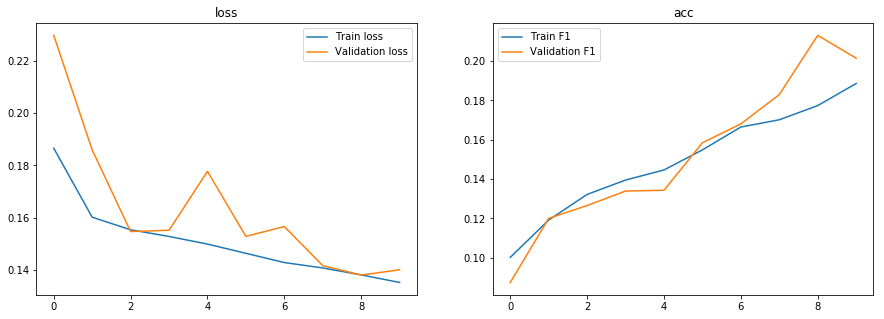

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(hist.epoch, hist.history["loss"], label="Train loss")
ax[0].plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(hist.epoch, hist.history["f1"], label="Train F1")
ax[1].plot(hist.epoch, hist.history["val_f1"], label="Validation F1")
ax[0].legend()
ax[1].legend()

In [14]:
hist.history

{'val_loss': [0.2296675331890583,
  0.18593593314290047,
  0.15471657924354076,
  0.1552180587733764,
  0.17770193703472614,
  0.15287379175424576,
  0.15662726644794317,
  0.14169096946716309,
  0.13809844851493835,
  0.1401079722356387],
 'val_acc': [0.9166433662176132,
  0.9392786547541618,
  0.948869876563549,
  0.9471948965424631,
  0.9409876242280006,
  0.9470562785863876,
  0.9467350126847689,
  0.9498464316129684,
  0.9515902996063232,
  0.9507586684861409],
 'val_f1': [0.08745483588427305,
  0.12004105746746063,
  0.1265845987945795,
  0.13393757927187522,
  0.13434849306941032,
  0.15851043537259102,
  0.16808864602203533,
  0.18299661204218864,
  0.21312746405601501,
  0.2015172866664731],
 'loss': [0.18655524159122341,
  0.16019989059873788,
  0.15539724699393,
  0.15284961412570588,
  0.14993693199455782,
  0.14640901638763756,
  0.14288125763829898,
  0.14081324475370172,
  0.13815444788440343,
  0.13527562004475271],
 'acc': [0.9346569495265226,
  0.9467643198750763,
  0

# Full validation
Perform validation on full validation dataset. Choose appropriate prediction threshold maximalizing the validation F1-score.

In [15]:
bestModel = load_model('./base.model', custom_objects={'f1': f1}) #, 'f1_loss': f1_loss})

In [16]:
lastValidationPredition = np.empty((0, 28))
lastValidationLabels = np.empty((0, 28))
for i in tqdm(range(len(validationGenerator))): 
    im, lbl = validationGenerator[i]
    scores = bestModel.predict(im)
    lastValidationPredition = np.append(lastValidationPredition, scores, axis=0)
    lastValidationLabels = np.append(lastValidationLabels, lbl, axis=0)
print(lastValidationPredition.shape, lastValidationLabels.shape)

100%|██████████| 25/25 [01:25<00:00,  2.91s/it]

(3108, 28) (3108, 28)


In [17]:
from sklearn.metrics import f1_score as off1
rng = np.arange(0, 1, 0.001)
f1s = np.zeros((rng.shape[0], 28))
for j,t in enumerate(tqdm(rng)):
    for i in range(28):
        p = np.array(lastValidationPredition[:,i]>t, dtype=np.int8)
        scoref1 = off1(lastValidationLabels[:,i], p, average='binary')
        f1s[j,i] = scoref1

  0%|          | 0/1000 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
  1%|          | 8/1000 [00:00<00:30, 32.14it/s]/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████| 1000/1000 [00:28<00:00, 36.97it/s]


In [18]:
print('Validation F1-score =', np.mean(np.max(f1s, axis=0)))

Validation F1-score = 0.2957271208453881


Probability threshold maximizing CV F1-score for each class:
[0.297 0.152 0.175 0.093 0.4   0.112 0.084 0.278 0.007 0.007 0.011 0.045
 0.165 0.138 0.08  0.    0.019 0.03  0.056 0.056 0.024 0.134 0.079 0.482
 0.233 0.144 0.025 0.   ]


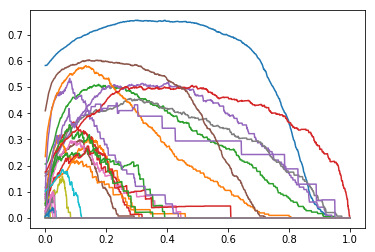

In [23]:
plt.plot(rng, f1s)
T = np.empty(28)
for i in range(28):
    T[i] = rng[np.where(f1s[:,i] == np.max(f1s[:,i]))[0][0]]
print('Probability threshold maximizing CV F1-score for each class:')
print(T)

In [24]:

testg = DataGenerator(testPaths, testLabels, BATCH_SIZE, SHAPE)
submit = pd.read_csv(PATH + '/sample_submission.csv')
P = np.zeros((testPaths.shape[0], 28))
for i in tqdm(range(len(testg))):
    images, labels = testg[i]
    score = bestModel.predict(images)
    P[i*BATCH_SIZE:i*BATCH_SIZE+score.shape[0]] = score

100%|██████████| 92/92 [08:27<00:00,  4.63s/it]


In [21]:
PP = np.array(P)

In [22]:
prediction = []

for row in tqdm(range(submit.shape[0])):
    
    str_label = ''
    
    for col in range(PP.shape[1]):
        if(PP[row, col] < T[col]):
            str_label += ''
        else:
            str_label += str(col) + ' '
    prediction.append(str_label.strip())
    
submit['Predicted'] = np.array(prediction)
submit.to_csv(PATH + '/sample_submission_1.csv', index=False)

100%|██████████| 11702/11702 [00:00<00:00, 55734.68it/s]
